In [1]:
import sys,os
import pylab as py
import numpy as np
from scipy.optimize import leastsq,minimize,root
from scipy.integrate import quad,fixed_quad, simps, dblquad
import pandas as pd
from tools import save,load,tex,ProgressBar,com,fill_between
from  matplotlib import rc
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
%matplotlib inline  
%config InlineBacend.figure_format = 'retina' 
rc('font',**{'family':'sans-serif','sans-serif':['Times-Roman']})
rc('text',usetex=True)
#import lhapdf
from numpy import linalg as LA
from scipy.interpolate import interp1d
import pandas as pd
from scipy.stats import norm
tex = lambda x: r'$\mathrm{'+x+'}$'
from scipy.stats import kde

# construct cov matrix

In [2]:
F=open('correlation_matrix.dat')
L=F.readlines()
F.close()
L=[l.strip() for l in L]
L=[l for l in L if l!='']
L=[l.split() for l in L]
L=[[l[i] for i in [0,1,2,3,4,7,8,9,10,11,12]] for l in L]
L=[L[i] for i in [0,1,2,3,4,7,8,9,10,11,12]]

rho=np.array([[float(x) for x in l] for l in L])
print 'shape of corr matrix:',rho.shape

err=[]
err.append(7.17002e-04) 
err.append(2.46543e-02)
err.append(7.15875e-03)
err.append(7.59358e-03)
err.append(4.01160e-02)
#err.append(5.38257e-01)
#err.append(7.93746e-01)
err.append(8.65518e-02)
err.append(1.25156e-01)
err.append(4.33534e-02)
err.append(3.17379e-01)
err.append(3.88934e-02)
err.append(2.64818e+00)
err=np.array(err)
cov=np.einsum('ij,i,j->ij',rho,err,err)
R=np.einsum('ii,ij,jj->ij',1/cov**0.5,cov,1/cov**0.5)


shape of corr matrix: (11, 11)


In [3]:
py.pcolor(R)
py.colorbar()
py.xlim(0,11)
py.ylim(0,11)

AttributeError: 'module' object has no attribute 'pcolor'

# setup mean values

In [4]:
par={}
par['BLNY']= {'range':None,'idx': 0,'val': 2.36166e-02,'pmin':None,'pmax':None}
par['Nu_c']= {'range':None,'idx': 1,'val': 2.61971e-01,'pmin':None,'pmax':None}
par['Nd_c']= {'range':None,'idx': 2,'val':-1.95220e-01,'pmin':None,'pmax':None}
par['au_c']= {'range':None,'idx': 3,'val': 1.69586e+00,'pmin':None,'pmax':None}
par['ad_c']= {'range':None,'idx': 4,'val': 3.20601e-01,'pmin':None,'pmax':None}
#par['bu_c']= {'range':None,'idx': 5,'val': 1.46831e-06,'pmin':None,'pmax':None}
#par['bd_c']= {'range':None,'idx': 6,'val': 3.61390e-03,'pmin':None,'pmax':None}
par['Nu_T']  = {'range':None,'idx': 5,'val': 8.54376e-01,'pmin':None,'pmax':None}
par['Nd_T']  = {'range':None,'idx': 6,'val':-9.99999e-01,'pmin':None,'pmax':None}
par['au_T']  = {'range':None,'idx': 7,'val': 6.88367e-01,'pmin':None,'pmax':None}
par['ad_T']  = {'range':None,'idx':8,'val': 1.79434e+00,'pmin':None,'pmax':None}
par['bu_T']  = {'range':None,'idx':9,'val': 4.81953e-02,'pmin':None,'pmax':None}
par['bd_T']  = {'range':None,'idx':10,'val': 6.99676e+00,'pmin':None,'pmax':None}

par['BLNY'].update({'pmin': 0,'pmax':None})
par['Nu_T'].update({'pmin':-1,'pmax':1})
par['Nd_T'].update({'pmin':-1,'pmax':1})
par['au_T'].update({'pmin': 0,'pmax':None})
par['ad_T'].update({'pmin': 0,'pmax':None})
par['bu_T'].update({'pmin': 0,'pmax':None})
par['bd_T'].update({'pmin': 0,'pmax':None})
par['Nu_c'].update({'pmin':-1,'pmax':1})
par['Nd_c'].update({'pmin':-1,'pmax':1})
par['au_c'].update({'pmin': 0,'pmax':None})
par['ad_c'].update({'pmin': 0,'pmax':None})
#par['bu_c'].update({'pmin': 0,'pmax':None})
#par['bd_c'].update({'pmin': 0,'pmax':None})

keys=par.keys()
ordered_keys = range(len(keys))
for k in keys:
  i=par[k]['idx']
  ordered_keys[i]=k

mean=np.array([par[k]['val'] for k in ordered_keys]) 

# gen sample

In [5]:
npar=10000
scale=1
sampleA=np.random.multivariate_normal(mean,cov*scale,npar)
SA0=pd.DataFrame(sampleA,columns=ordered_keys) 
SA1=SA0
for k in par.keys():
  pmin=par[k]['pmin']
  pmax=par[k]['pmax']
  if pmin!=None: SA1=SA1[SA1[k]>pmin]
  if pmax!=None: SA1=SA1[SA1[k]<pmax]
print 'scale:',scale
print 'initial sample size:',SA0.index.size
print 'after cuts:',SA1.index.size


scale: 1
initial sample size: 10000
after cuts: 4236


In [6]:
npar=10000*100
scale=1./1000.
sampleB=np.random.multivariate_normal(mean,cov*scale,npar)
SB0=pd.DataFrame(sampleB,columns=ordered_keys) 
SB1=SB0
for k in par.keys():
  pmin=par[k]['pmin']
  pmax=par[k]['pmax']
  if pmin!=None: SB1=SB1[SB1[k]>pmin]
  if pmax!=None: SB1=SB1[SB1[k]<pmax]
print 'scale:',scale
print 'initial sample size:',SB0.index.size
print 'after cuts:',SB1.index.size

scale: 0.001
initial sample size: 1000000
after cuts: 500323


In [7]:
def get_h(x,S):
  Nu=S['Nu_T'].values
  au=S['au_T'].values
  bu=S['bu_T'].values

  Nd=S['Nd_T'].values
  ad=S['ad_T'].values
  bd=S['bd_T'].values
  
  hu=Nu*x**au*(1-x)**bu*(au+bu)**(au+bu)/au**au/bu**bu
  hd=Nd*x**ad*(1-x)**bd*(ad+bd)**(ad+bd)/ad**ad/bd**bd
  
  hu=np.array([h for h in hu if np.isnan(h)==False])
  hd=np.array([h for h in hd if np.isnan(h)==False])
  return hu,hd

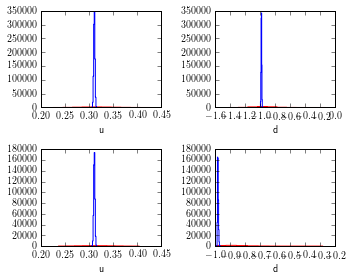

In [8]:
ncols,nrows=2,2
plt.figure(figsize=(ncols*2.5,nrows*2))
huA,hdA=get_h(0.18,SA0)
huB,hdB=get_h(0.18,SB0)

ax=plt.subplot(nrows,ncols,1)
ax.hist(huA,histtype='step',color='r')
ax.hist(huB,histtype='step',color='b')
ax.set_xlabel('u')

ax=plt.subplot(nrows,ncols,2)
ax.hist(hdA,histtype='step',color='r')
ax.hist(hdB,histtype='step',color='b')
ax.set_xlabel('d')

huA,hdA=get_h(0.18,SA1)
huB,hdB=get_h(0.18,SB1)

ax=plt.subplot(nrows,ncols,3)
ax.hist(huA,histtype='step',color='r')
ax.hist(huB,histtype='step',color='b')
ax.set_xlabel('u')

ax=plt.subplot(nrows,ncols,4)
ax.hist(hdA,histtype='step',color='r')
ax.hist(hdB,histtype='step',color='b')
ax.set_xlabel('d')

plt.tight_layout()

In [9]:
ncols,nrows=2,1
plt.figure(figsize=(ncols*2.5,nrows*2))



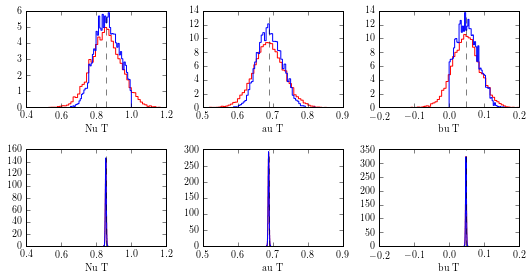

In [10]:
ncols,nrows=3,2
plt.figure(figsize=(ncols*2.5,nrows*2))
cnt=0
for k in ['Nu_T','au_T','bu_T']:
  cnt+=1
  ax=plt.subplot(nrows,ncols,cnt)
  H,E,p=ax.hist(SA0[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='r') 
  H,E,p=ax.hist(SA1[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='b') 
  ax.locator_params(axis = 'x', nbins=5)
  ax.set_xlabel(tex(k.replace('_','~')))
  ax.axvline(par[k]['val'],color='k',ls='--',alpha=0.5,label=tex('mean'))
  if k=='Nu_T':ax.set_xlim(0.4,1.2)
  if k=='au_T':ax.set_xlim(0.5,0.9)
  if k=='bu_T':ax.set_xlim(-0.2,0.2)
  
for k in ['Nu_T','au_T','bu_T']:
  cnt+=1
  ax=plt.subplot(nrows,ncols,cnt)
  H,E,p=ax.hist(SB0[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='r') 
  H,E,p=ax.hist(SB1[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='b') 
  ax.locator_params(axis = 'x', nbins=5)
  ax.set_xlabel(tex(k.replace('_','~')))
  ax.axvline(par[k]['val'],color='k',ls='--',alpha=0.5,label=tex('mean'))
  if k=='Nu_T':ax.set_xlim(0.4,1.2)
  if k=='au_T':ax.set_xlim(0.5,0.9)
  if k=='bu_T':ax.set_xlim(-0.2,0.2)
  
plt.tight_layout()

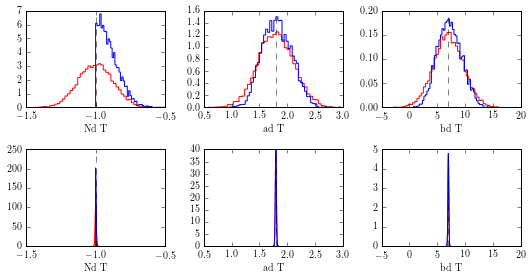

In [11]:
ncols,nrows=3,2
plt.figure(figsize=(ncols*2.5,nrows*2))
cnt=0
for k in ['Nd_T','ad_T','bd_T']:
  cnt+=1
  ax=plt.subplot(nrows,ncols,cnt)
  H,E,p=ax.hist(SA0[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='r') 
  H,E,p=ax.hist(SA1[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='b') 
  ax.locator_params(axis = 'x', nbins=5)
  ax.set_xlabel(tex(k.replace('_','~')))
  ax.axvline(par[k]['val'],color='k',ls='--',alpha=0.5,label=tex('mean'))
  if k=='Nd_T':ax.set_xlim(-1.5,-0.5)
  if k=='ad_T':ax.set_xlim(0.5,3)
  if k=='bd_T':ax.set_xlim(-5,20)
  
for k in ['Nd_T','ad_T','bd_T']:
  cnt+=1
  ax=plt.subplot(nrows,ncols,cnt)
  H,E,p=ax.hist(SB0[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='r') 
  H,E,p=ax.hist(SB1[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='b') 
  ax.locator_params(axis = 'x', nbins=5)
  ax.set_xlabel(tex(k.replace('_','~')))
  ax.axvline(par[k]['val'],color='k',ls='--',alpha=0.5,label=tex('mean'))
  if k=='Nd_T':ax.set_xlim(-1.5,-0.5)
  if k=='ad_T':ax.set_xlim(0.5,3)
  if k=='bd_T':ax.set_xlim(-5,20)
  
plt.tight_layout()

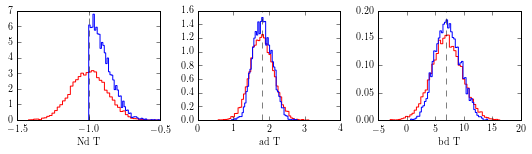

In [12]:
ncols,nrows=3,4
plt.figure(figsize=(ncols*2.5,nrows*2))
cnt=0
for k in ['Nd_T','ad_T','bd_T']:
  cnt+=1
  ax=plt.subplot(nrows,ncols,cnt)
  H,E,p=ax.hist(SA0[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='r') 
  H,E,p=ax.hist(SA1[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='b') 
  ax.locator_params(axis = 'x', nbins=5)
  ax.set_xlabel(tex(k.replace('_','~')))
  ax.axvline(par[k]['val'],color='k',ls='--',alpha=0.5,label=tex('mean'))
plt.tight_layout()

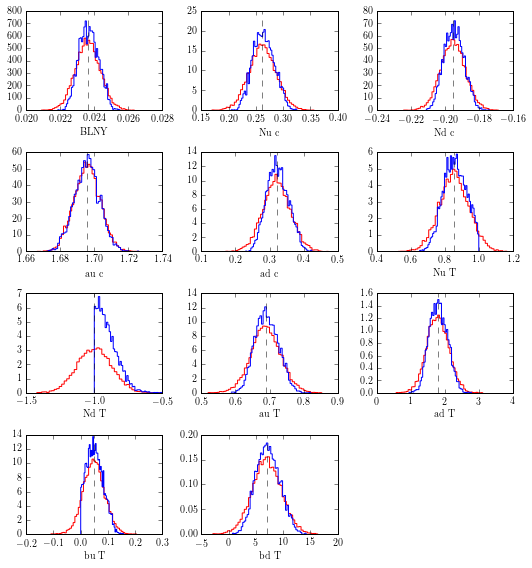

In [13]:
ncols,nrows=3,4
plt.figure(figsize=(ncols*2.5,nrows*2))
cnt=0
for k in ordered_keys:
  cnt+=1
  ax=plt.subplot(nrows,ncols,cnt)
  H,E,p=ax.hist(SA0[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='r') 
  H,E,p=ax.hist(SA1[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='b') 
  ax.locator_params(axis = 'x', nbins=5)
  ax.set_xlabel(tex(k.replace('_','~')))
  ax.axvline(par[k]['val'],color='k',ls='--',alpha=0.5,label=tex('mean'))
plt.tight_layout()

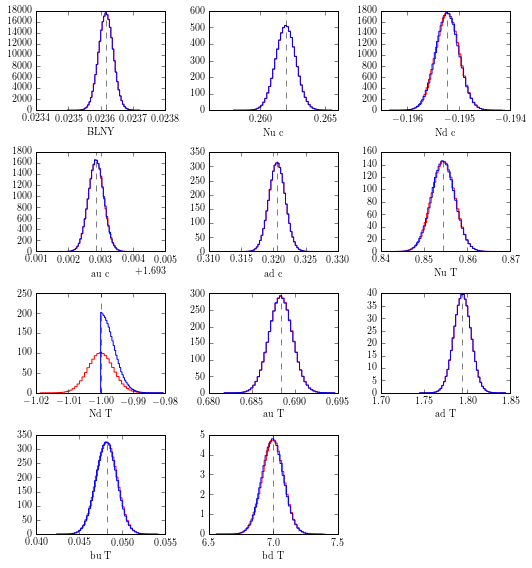

In [14]:
ncols,nrows=3,4
plt.figure(figsize=(ncols*2.5,nrows*2))
cnt=0
for k in ordered_keys:
  cnt+=1
  ax=plt.subplot(nrows,ncols,cnt)
  H,E,p=ax.hist(SB0[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='r') 
  H,E,p=ax.hist(SB1[k].values,bins=50,histtype='step',normed=1,range=par[k]['range'],color='b') 
  ax.locator_params(axis = 'x', nbins=5)
  ax.set_xlabel(tex(k.replace('_','~')))
  ax.axvline(par[k]['val'],color='k',ls='--',alpha=0.5,label=tex('mean'))
plt.tight_layout()

# save sample

In [14]:
S1=SB0
fname='params1000L.dat'
sample=np.zeros((13,S1.index.size))
sample[0]  = S1['BLNY'].values
sample[1]  = S1['Nu_c'].values 
sample[2]  = S1['Nd_c'].values
sample[3]  = S1['au_c'].values
sample[4]  = S1['ad_c'].values
sample[5]  = np.zeros(S1.index.size) + 1.46831e-06
sample[6]  = np.zeros(S1.index.size) + 3.61390e-03
sample[7]  = S1['Nu_T'].values
sample[8]  = S1['Nd_T'].values
sample[9]  = S1['au_T'].values
sample[10] = S1['ad_T'].values
sample[11] = S1['bu_T'].values
sample[12] = S1['bd_T'].values
sample=np.transpose(sample)
np.savetxt('data/%s'%fname,sample,delimiter=' ',fmt='%0.10e')